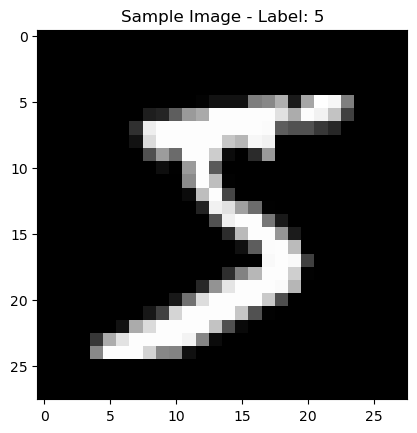

In [29]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision.models as models
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Display a sample image
sample_image, label = mnist_dataset[0]
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"Sample Image - Label: {label}")
plt.show()




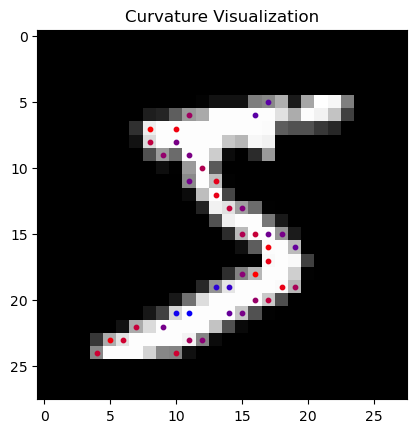

Curvatures: [1.10714872 1.11351806 1.95911504 2.96173915 3.11834103 2.35619449
 1.81577499 1.49546744 1.51529782 1.41419445 2.15879893 2.43933572
 3.01723766 2.8753406  3.14159264 1.69515132 0.64987045 0.51914611
 0.10308161 0.19739556 1.44644133 2.43296638 2.55359005 2.97975522
 2.51178932 2.53930531 2.03444394 1.69515132 1.25656443 1.48405799
 1.86503089 2.35619449 2.8753406  2.066348   1.23150371 1.46013911
 1.37340077 1.61837943 2.41495031 2.85779854 2.8198421  2.15879893]


In [30]:


def calculate_curvature(contour, k=5):
    """
    Calculate the curvature for each point on the contour.
    We calculate the curvature based on the angle formed by triplets of points.

    Parameters:
    - contour: The contour points (a list of points forming the contour)
    - k: Number of neighboring points to consider for curvature estimation (default is 5)

    Returns:
    - curvatures: A list of curvatures for each point on the contour
    """
    curvatures = []
    # Loop over contour points
    contour = np.squeeze(contour)  # Remove single
    for i in range(k, len(contour) - k):
        p1 = contour[i - k]  # Previous point
        p2 = contour[i]      # Current point
        p3 = contour[i + k]  # Next point

        # Calculate vectors between the points
        v1 = p1 - p2
        v2 = p3 - p2

        # Calculate the angle between the vectors
        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

        # Clip cosine_angle to be in the range [-1, 1]
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

        # Calculate the curvature as the angle between the vectors
        angle = np.arccos(cosine_angle)
        curvature = np.abs(angle)
        
        curvatures.append(curvature)

    return np.array(curvatures)

def extract_features(image_tensor):
    # Convert tensor to NumPy array and reshape to a 2D grayscale image
    image = image_tensor.squeeze().numpy()
    image = (image * 255).astype(np.uint8)

    # Threshold the image
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    # Calculate shape features (area, perimeter)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    # Calculate curvature (simplified curvature calculation)
    curvatures = calculate_curvature(cnt)
    visualize_curvature(image, cnt, Curvature)
    #return np.concatenate(([area, perimeter], curvatures), axis=0)
    return curvatures

# Visualize the curvature on the contour
def visualize_curvature(image, contour, curvatures):
    plt.imshow(image, cmap='gray')
    for i, point in enumerate(contour):
        if i < len(curvatures):  # Ensure the curvature data is available
            curvature = curvatures[i]
            # Map curvature to color (larger curvature -> red, smaller -> blue)
            color = (curvature / np.max(curvatures), 0, 1 - curvature / np.max(curvatures))
            plt.scatter(point[0][0], point[0][1], color=color, s=10)  # Plot contour point with color
    plt.title('Curvature Visualization')
    plt.show()

# Example feature extraction
Curvature = extract_features(sample_image)
print(f"Curvatures: {Curvature}")


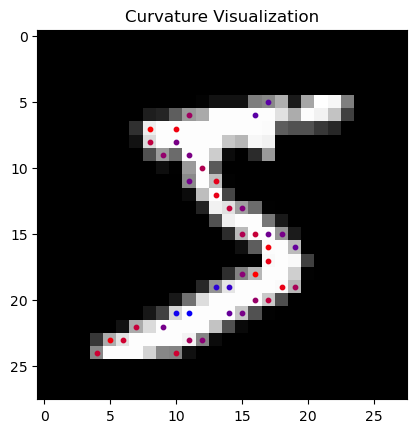

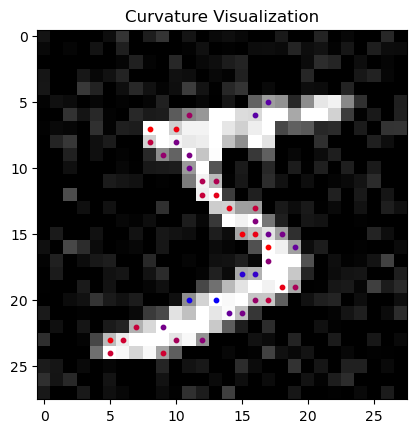

L2 Distance between original and noisy curvatures: 2.8563292552070583


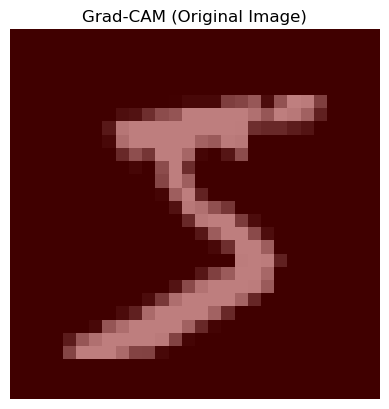

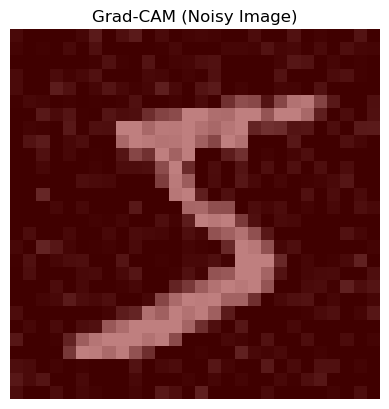

In [31]:
def convert_grayscale_to_rgb(image_tensor):
    # Ensure image_tensor is 4D: [batch_size, 1, height, width]
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(1)  # Add channel dimension if missing

    # Repeat the grayscale channel 3 times to make it RGB
    image_tensor_rgb = image_tensor.repeat(1, 3, 1, 1)  # [batch_size, 3, height, width]
    return image_tensor_rgb


# Add Gaussian noise to the image
def add_gaussian_noise(image_tensor, mean=0, std=0.1):
    noise = torch.randn(image_tensor.size()) * std + mean
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are between 0 and 1
    return noisy_image

# Calculate L2 distance between original and noisy curvature features
def calculate_l2_distance(original_curvatures, noisy_curvatures):
    min_len = min(len(original_curvatures), len(noisy_curvatures))
    if min_len > 0:
        original_curvatures = original_curvatures[:min_len]
        noisy_curvatures = noisy_curvatures[:min_len]
        l2_dist = np.linalg.norm(original_curvatures - noisy_curvatures)
        return l2_dist
    return None

def visualize_cam(image, cam, title="Grad-CAM"):
    # Ensure image is converted from tensor to NumPy and scaled between 0-255
    image = tensor_to_image(image.squeeze())  # Convert from tensor
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # Normalize between 0-1
    image = np.uint8(255 * image)  # Scale to 0-255 for visualization

    # Transpose image to (height, width, channels) for OpenCV
    if image.shape[0] == 3:  # If the image has shape (3, height, width)
        image = image.transpose(1, 2, 0)  # Convert to (height, width, 3)

    # Ensure the image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Resize the CAM to the same size as the image
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))

    # Normalize CAM and convert to uint8
    cam_min, cam_max = cam_resized.min(), cam_resized.max()
    
    if cam_max - cam_min > 1e-8:  # Ensure there is a range in the CAM values
        cam_resized = (cam_resized - cam_min) / (cam_max - cam_min)  # Normalize CAM
    else:
        cam_resized = np.zeros_like(cam_resized)  # If no range, just set CAM to zeros
    
    heatmap = np.uint8(255 * cam_resized)  # Convert CAM to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply heatmap

    # Ensure heatmap is the same size as the image
    if heatmap.shape[:2] != image.shape[:2]:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Overlay the heatmap on the original image
    # Ensure that both image and heatmap have 3 channels
    if heatmap.shape[2] != image.shape[2]:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB if needed

    # Now they both should be RGB and have the same size
    superimposed_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    # Show the superimposed image
    plt.imshow(superimposed_image)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()





# Gradient Map (Grad-CAM) for visualization
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.forward_hook = None
        self.backward_hook = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.forward_hook = self.target_layer.register_forward_hook(forward_hook)
        self.backward_hook = self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        class_score = output[:, target_class]
        class_score.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = F.relu(torch.sum(weights * self.feature_maps, dim=1)).squeeze()

        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize CAM
        # Update normalization in generate_cam function
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Add small epsilon to avoid division by zero

        return cam.detach().numpy()

# Main processing
sample_image_tensor = sample_image.unsqueeze(0)  # Add batch dimension
sample_image_tensor_rgb = convert_grayscale_to_rgb(sample_image_tensor)

# Add noise to the sample image
noisy_image_tensor = add_gaussian_noise(sample_image_tensor)
noisy_image_tensor_rgb = convert_grayscale_to_rgb(noisy_image_tensor)

# Extract curvature features from original and noisy images
original_curvatures = extract_features(sample_image_tensor)
noisy_curvatures = extract_features(noisy_image_tensor)

# Calculate L2 distance
l2_distance = calculate_l2_distance(original_curvatures, noisy_curvatures)
print(f"L2 Distance between original and noisy curvatures: {l2_distance}")

# Load a pre-trained ResNet model for Grad-CAM
model = models.resnet50(pretrained=True)
target_layer = model.layer4[2].conv3  # Target the last convolutional layer

# Create Grad-CAM object
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM for original and noisy images
original_cam = grad_cam.generate_cam(sample_image_tensor_rgb)
noisy_cam = grad_cam.generate_cam(noisy_image_tensor_rgb)

# Visualize original Grad-CAM
visualize_cam(sample_image_tensor_rgb, original_cam, title="Grad-CAM (Original Image)")

# Visualize noisy Grad-CAM
visualize_cam(noisy_image_tensor_rgb, noisy_cam, title="Grad-CAM (Noisy Image)")


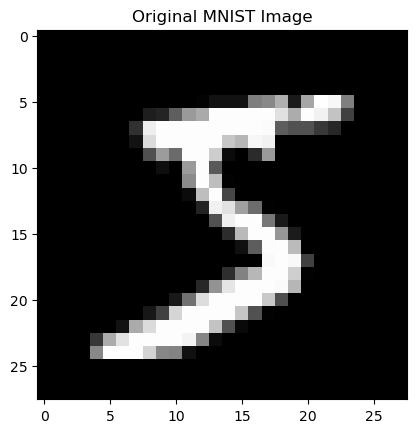

Extracted Features Shape: torch.Size([1, 1000])


In [32]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Define preprocessing (resize to 224x224, convert to RGB, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resizing 28x28 to 224x224
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load MNIST dataset
mnist_dataset = MNIST(root='./data', train=True, download=True)

# Display a sample image
def display_image(image_pil):
    # Convert the PIL image to a NumPy array
    image_np = np.array(image_pil)
    plt.imshow(image_np, cmap='gray')
    plt.title("Original MNIST Image")
    plt.show()

# Preprocess the MNIST image to fit ResNet
def preprocess_mnist_image(img):
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension
    return img

# Pick a sample MNIST image (e.g., index 0)
mnist_image, label = mnist_dataset[0]  # (PIL image, label)

# Display the original MNIST image (before transformation)
display_image(mnist_image)

# Preprocess the MNIST image
image_tensor = preprocess_mnist_image(mnist_image)

# Extract features using ResNet-50
with torch.no_grad():
    features = model(image_tensor)

# Display the shape of the extracted features
print(f"Extracted Features Shape: {features.shape}")


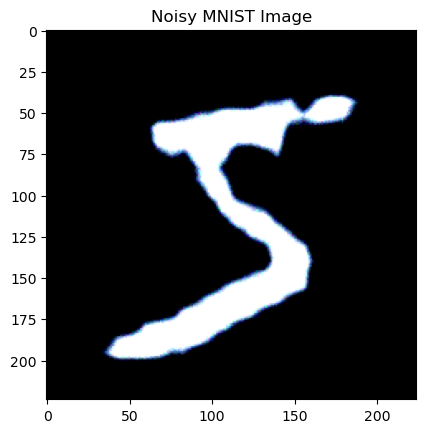

L2 Distance between original and noisy features: 56.82991027832031


In [33]:
def add_gaussian_noise(image_tensor, mean=0, std=0.1):
    noise = torch.randn(image_tensor.size()) * std + mean
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are between 0 and 1
    return noisy_image

noisy_image_tensor = add_gaussian_noise(image_tensor)

with torch.no_grad():
    original_features = model(image_tensor)
    noisy_features = model(noisy_image_tensor)

# Display the noisy image (after adding noise)
plt.imshow(noisy_image_tensor.squeeze().permute(1, 2, 0).numpy())  # Reorder dimensions to (H, W, C)
plt.title("Noisy MNIST Image")
plt.show()

# Calculate the L2 distance between the features of original and noisy images
def l2_distance(features1, features2):
    return torch.norm(features1 - features2)

distance = l2_distance(original_features, noisy_features)
print(f"L2 Distance between original and noisy features: {distance.item()}")